In [1]:
from wandb.keras import WandbCallback
import sys
import time
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from utils.utils_mine import *
import tensorflow as tf
import tensorflow.keras as keras
from datetime import date
import numpy as np
import random
import tensorflow_addons as tfa
import wandb
import gc
from classifiers.classifier_factory import create_classifier
from scripts.plot.DL.read_LOO_nestedCV_gnntr import get_sorted_loo_array




2024-04-06 20:15:05.842724: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-06 20:15:05.863256: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:7704] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-06 20:15:05.863281: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-06 20:15:05.863289: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1520] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-06 20:15:05.867565: I tensorflow/core/platform/cpu_feature_g

(64, 52, 2500)


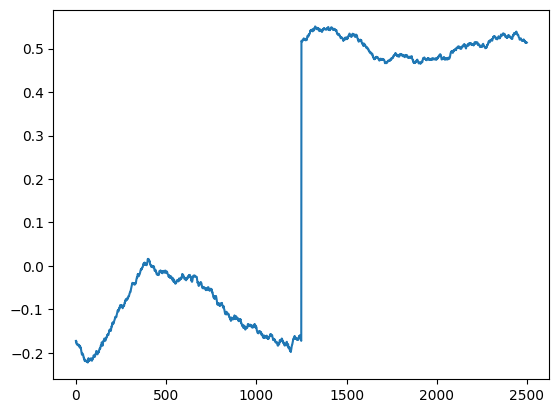

In [3]:
data = np.load('/home/jy/Documents/fnirs/treatment_response/fnirs-depression-deeplearning/allData/prognosis/pretreatment_response/hb_data.npy')
print(data.shape)

plt.plot(np.mean(data, axis=(0, 1)))

In [9]:
pretreatment_data_pth = '/Users/shanxiafeng/Documents/Project/Research/fnirs-prognosis/code/fnirs-treatment-response-prediction/allData/prognosis/pretreatment_response/hb_data.npy'
pretreatment_data_pth = '/Users/shanxiafeng/Documents/Project/Research/fnirs-prognosis/code/fnirs-treatment-response-prediction/allData/prognosis/previous_pre_treatment_hamd_reduction_50/hb_data_v1.npy'
pretreatment_data = np.load(pretreatment_data_pth, allow_pickle=True)

print(pretreatment_data.shape)

(65, 52, 1250, 3)


In [ ]:
import sys
import glob
sys.path.append('/Users/shanxiafeng/Documents/Project/Research/fnirs-prognosis/code/fnirs-treatment-response-prediction')

import time
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import cross_val_score,train_test_split
from utils.utils_mine import*
import tensorflow as tf
import tensorflow.keras as keras
from datetime import date
import numpy as np
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests
import pingouin as pg
import subprocess
import collections

# path of data 


def read_from_file(example_path): # Open the file and read through the first few lines to find where the data starts
    with open(example_path, 'r') as file:
        lines = file.readlines()
        data_start_line = None
        for i, line in enumerate(lines):
            if 'Data' in line:  # This should match the unique identifier of the data section
                data_start_line = i + 1
                # print(lines[data_start_line])
                break

    if data_start_line is not None:

        # Read the data section, skipping the lines of the metadata
        data = pd.read_csv(example_path, skiprows=data_start_line)

        # Now you have metadata and data as separate DataFrames
        # print(data)
    else:
        print("Data section not found.")
        
    np_data = data.to_numpy()
    ch_data = np_data[:, 1:1+52]

    return ch_data

def get_file_name(path, rest):
    file_pattern = os.path.join(path, rest)
    file_list = glob.glob(file_pattern)
    return file_list

def check_replicate_subject(all_subject):
    all_subject_index = [i[3:] for i in all_subject]
    all_subject_index = np.array(all_subject_index).astype(int)
    print(f'all_subject_index -> {all_subject_index}')
    print('all_subject_index.shape -> ', all_subject_index.shape)
    print('len(np.unique(all_subject_index)) -> ', len(np.unique(all_subject_index)))
    is_replicated = len(np.unique(all_subject_index)) != len(all_subject_index)
    print(f"Is there any replicated number in all_subject_index? {is_replicated}")
    if is_replicated:
        replicated_elements = [item for item, count in collections.Counter(all_subject_index).items() if count > 1]
        replicated_indices = np.where(np.isin(all_subject_index, replicated_elements))[0]
        print(f" Element {replicated_elements} shows up in the following indices: {replicated_indices}")
    else: return None
    print(f' now will return replicated_indices[0::2]')
    return replicated_indices[0::2]


follow_up_fold = '/Users/shanxiafeng/Documents/Project/Research/fnirs-prognosis/code/fnirs-treatment-response-prediction/allData/RawData'
T8_path = follow_up_fold + '/T8_fnirs/Session 2_VFT'
base_patient_path = follow_up_fold + '/Baseline_fnirs/Patients'
cli_path = '/Users/shanxiafeng/Documents/Project/Research/fnirs-prognosis/code/fnirs-treatment-response-prediction/allData/fNIRS x MDD Data_Demographics_Clinical.xlsx'

cgi_sgs_data = pd.read_excel(cli_path, sheet_name='SDS_CGI_All Timepoints')

# cgi_sgs_data.iloc[:, 1:7]

excel_data = pd.read_excel(cli_path, sheet_name='Summary T0T8_fNIRS Analysis')
# cgi_sgs_data = pd.read_excel(cgi_sgs_path, sheet_name='SDS_CGI_All Timepoints')
label_hamd = []
demografic_data = []
baseline_clinical_data = []

def check_existing_subject_in_fnirs_path(path):
    for hb in ['_Oxy.csv', '_Deoxy.csv']:
        tmp = 0
        all_subject = []
        for i in os.listdir(path):
            if i[-len(hb):] == hb:
                subject = i.split(' ')[0]
                all_subject.append(subject)
                file_pattern = os.path.join(path, subject+'*'+hb)
                file_list = glob.glob(file_pattern)
                if len(file_list) < 1:
                    print(file_list)
                tmp+=1
        all_subject.sort()
    return all_subject

all_subject = check_existing_subject_in_fnirs_path(T8_path)
print(f'all_subject -> {len(all_subject)}')

# def get_file_name(path, rest):
#     file_pattern = os.path.join(path, rest)
#     file_list = glob.glob(file_pattern)
#     return file_list
# # according to the subject name of all_subject create array now 

mdd_subject_base_post = np.zeros((len(all_subject), 1251, 52, 2, 2))# []#np.zeros((len(all_subject), 1251, 52, 2)) # time, channel, hbo/hbr
all_involve_subject = []
for sub_index, subject in enumerate(all_subject):
    hamd_of_id_t1 = excel_data[excel_data['Subject ID'] == subject]['HAM-D Questionnaire (T1)'].iloc[0]
    hamd_of_id_t8 = excel_data[excel_data['Subject ID'] == subject]['HAM-D Questionnaire (T8)'].iloc[0]
    demographic = excel_data[excel_data['Subject ID'] == subject].iloc[:, 2:13]
    clinical = cgi_sgs_data[cgi_sgs_data['Subject ID'] == subject].iloc[:, 1:7]
    if type(hamd_of_id_t8) is not int:
        print(hamd_of_id_t8)
        continue
    all_involve_subject.append(subject)
    sub_label = [hamd_of_id_t1, hamd_of_id_t8]
    label_hamd.append(sub_label)
    demografic_data.append(demographic)
    baseline_clinical_data.append(clinical)
    for hb_index, hb in enumerate(['_Oxy.csv', '_Deoxy.csv']):

        base_hb_file = get_file_name(base_patient_path, subject+'*'+hb)
        base_hb = read_from_file(base_hb_file[0])
        
        post_hb_file = get_file_name(T8_path, subject+'*'+hb)
        post_hb = read_from_file(post_hb_file[0])
        
        mdd_subject_base_post[sub_index, :, :, hb_index, 0] = base_hb
        mdd_subject_base_post[sub_index, :, :, hb_index, 1] = post_hb
        # print(f"sub :{sub_index} ({subject}) hb: {hb_index} was given base value {np.mean(base_hb)} and post value {np.mean(post_hb)}")

mdd_subject_base = np.array(mdd_subject_base_post)
label_hamd = np.array(label_hamd)
demografic_data = np.squeeze(np.array(demografic_data))
baseline_clinical_data = np.squeeze(np.array(baseline_clinical_data))


# check if there is any replicated subject, becasue there might be two files with same subject names
replicated_indices = check_replicate_subject(all_subject)
print(f'return replicated_indices {replicated_indices}')

print(f'mdd_subject_base -> {mdd_subject_base.shape}')
print(f'label_hamd -> {label_hamd.shape}')
print(f'demografic_data -> {demografic_data.shape}')
print(f'baseline_clinical_data -> {baseline_clinical_data.shape}')
print('all_involve_subject', all_involve_subject)

# delete the replicated subject
if replicated_indices:
    mdd_subject_base = np.delete(mdd_subject_base, replicated_indices, axis=0)
    label_hamd = np.delete(label_hamd, replicated_indices, axis=0)
    demografic_data = np.delete(demografic_data, replicated_indices, axis=0)
    baseline_clinical_data = np.delete(baseline_clinical_data, replicated_indices, axis=0)




# baseline HAMD will be added into the baseline_clinical_data 
baseline_clinical_data = np.concatenate((baseline_clinical_data, label_hamd[:, 0:1]), axis=1)


print(f'mdd_subject_base -> {mdd_subject_base.shape}')
print(f'label_hamd -> {label_hamd.shape}')
print(f'demografic_data -> {demografic_data.shape}')
print(f'baseline_clinical_data -> {baseline_clinical_data.shape}')
print('all_involve_subject', all_involve_subject)

# calculate remission 
label_response = np.zeros(label_hamd.shape[0])
for i, val in enumerate(label_hamd):
    if (val[1] - val[0]) / val[0] <= -0.5:
        label_response[i] = 1
        # print('label_responder[i] -> ', label_responder[i])
        # print('val -> ',val)
print(label_response)
count = np.count_nonzero(label_response == 1)
print(f" number of remission subject in posttreatment -> {count}")


# # modify the hb data (46, 1251, 52, 2, 2) to be like (subject, 52, 2500, 2)
# mdd_subject_base = mdd_subject_base[:, :1250, :, :, :]
# mdd_subject_base = mdd_subject_base.transpose((0, 2, 1, 3, 4))
# mdd_subject_base = mdd_subject_base.reshape((mdd_subject_base.shape[0], 52, 2500, 2))

# hb_data = mdd_subject_base
# print('hb_data -> ', hb_data.shape)

In [29]:
mdd_subject_base.shape

mdd_subject_base = np.transpose(mdd_subject_base, (0, 2, 1, 3, 4))
hb_data = np.empty((mdd_subject_base.shape[0], 52, 2500, 2))
hbo = mdd_subject_base[:, :, :1250, 0, :]
hbr = mdd_subject_base[:, :, :1250, 1, :]
hb_data[:, :, :1250, :] = hbo
hb_data[:, :, 1250:, :] = hbr


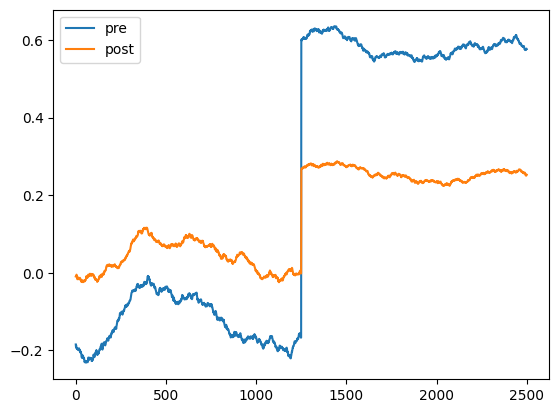

In [31]:
hb_data_baseline = hb_data[..., 0]
hb_data_post = hb_data[..., 1]
plt.plot(np.mean(hb_data_baseline, axis=(0, 1)), label = 'pre')
plt.plot(np.mean(hb_data_post, axis=(0, 1)), label = 'post')
plt.legend()

In [4]:
def stratified_k_fold_cross_validation_with_holdout_with_cli_demo(data, label, cli_demo, k, num_of_k_fold, adj=None, seed=42):
    total_amount = data.shape[0] 
    data, cli_demo, label = shuffle_data_demo_label(data, label, cli_demo, seed)
    label_not_onehot = np.argmax(label, axis=1)

    
    
    Y_train, Y_val, Y_test = onehotEncode(Y_train).astype('float32'), onehotEncode(Y_val).astype('float32'), onehotEncode(Y_test).astype('float32')
    if adj is None:
        return X_train, Y_train, X_val, Y_val, X_test, Y_test
    else:
        adj_train = adj[:X_train.shape[0]]
        adj_val = adj[:X_val.shape[0]]
        adj_test = adj[:X_test.shape[0]]
        return X_train, Y_train, X_val, Y_val, X_test, Y_test, adj_train, adj_val, adj_test
    
    
    

[0.  0.2 0.  0.  0.  0.6 0.2 0.  0.  0.2 0.  0.6 0.  0.2 0.  0.2 0.2 0.2
 0.2 0.  0.  0.2 0.8 0.  0.2 0.2 0.8 0.6 0.4 0.4 0.8 0.2 0.  0.  0.2 0.8
 0.4 0.2 0.4 1.  0.2 0.  0.2 0.6 0.2 0.  0.2 0.  0.8 1.  0.2 0.2 0.2 0.2
 0.2 0.8 1.  0.2 0.6 0.  0.  0.  0.  0. ]


In [27]:
from utils.utils_mine import simply_read_data_fnirs
file_name = '/home/jy/Documents/fnirs/treatment_response/fnirs-depression-deeplearning/allData/prognosis/pretreatment_response'
model_name = 'gnn_transformer'
hb_path = 'hb_data.npy'
adj_path = 'adj_matrix.npy'
cli_demo_path = 'nor_demo_cli_merge_data.npy'
data, label, adj, cli_demo = simply_read_data_fnirs(file_name, model_name, hb_path, adj_path, cli_demo_path)
def shuffle_data_demo_label(data, label, demo, seed):
    random.seed(seed)
    combined = list(zip(data, demo, label))
    random.shuffle(combined)
    data, demo, label = zip(*combined)
    return np.array(data), np.array(demo), np.array(label) 

seed = np.random.randint(0, 10000)
data, cli_demo, label = shuffle_data_demo_label(data, label, cli_demo, seed)



In [39]:
k = 0
num_of_k_fold = 5

tmp_label = label.copy()
tmp_label = np.argmax(tmp_label, axis=1)
print(np.sum(tmp_label))
index_1 = np.where(tmp_label == 1)[0]
index_0 = np.where(tmp_label == 0)[0]

num_of_test_data_1 = int(len(index_1) // 3)
num_of_test_data_0 = int(len(index_0) // 3)

test_index_1 = index_1[:num_of_test_data_1]
test_index_0 = index_0[:num_of_test_data_0]

val_train_index_1 = index_1[num_of_test_data_1:]
val_train_index_0 = index_0[num_of_test_data_0:]

one_fold_number_1 = len(val_train_index_1) // num_of_k_fold
one_fold_number_0 = len(val_train_index_0) // num_of_k_fold


val_index_1 = val_train_index_1[k*one_fold_number_1:(k+1)*one_fold_number_1]
val_index_0 = val_train_index_0[k*one_fold_number_0:(k+1)*one_fold_number_0]

train_index_1 = np.concatenate([val_train_index_1[:k*one_fold_number_1], val_train_index_1[(k+1)*one_fold_number_1:]])
train_index_0 = np.concatenate([val_train_index_0[:k*one_fold_number_0], val_train_index_0[(k+1)*one_fold_number_0:]])


test_index = np.concatenate([test_index_1, test_index_0])
val_index = np.concatenate([val_index_1, val_index_0])
train_index = np.concatenate([train_index_1, train_index_0])



X_train = data[train_index]
X_val = data[val_index]
X_test = data[test_index]

Y_train = label[train_index]
Y_val = label[val_index]
Y_test = label[test_index]

cli_demo_train = cli_demo[train_index]
cli_demo_val = cli_demo[val_index]
cli_demo_test = cli_demo[test_index]

adj_train = adj[train_index]
adj_val = adj[val_index]
adj_test = adj[test_index]



print("cli_demo_train -> ", cli_demo_train.shape)
print("cli_demo_val -> ", cli_demo_val.shape)
print("cli_demo_test -> ", cli_demo_test.shape)

14
cli_demo_train ->  (36, 18)
cli_demo_val ->  (8, 18)
cli_demo_test ->  (20, 18)


In [12]:
from utils.utils_mine import generate_fnirs_adj
import numpy as np
hb = np.zeros((46,1,1,1))
number_of_subjects = hb.shape[0]
adj = generate_fnirs_adj().toarray()
adj = np.tile(adj, (number_of_subjects, 1, 1))
print("adj_matrix shape: ", adj.shape)

(46, 52, 52)


/Users/shanxiafeng/miniconda3/lib/python3.9/site-packages/scipy/sparse/_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


In [6]:
import importlib
input = 'version1'
config_name = "configs." + input
config = importlib.import_module(config_name)
print(config.name)



Hello world!


In [4]:
path = '/Users/shanxiafeng/Documents/Project/Research/fnirs-prognosis/code/fnirs-treatment-response-prediction/allData/prognosis/pre_treatment_hamd_reduction_50/label_remission.npy'
a = np.load(path)

# a = a[:64]

print(a.shape)

# np.save(path, a)


(64,)


In [26]:
seed = 42
random.seed(seed)
np.random.seed(seed)

data = np.arange(100).reshape(10,5,2)
# data = np.arange(10)
label= np.arange(10)


# Shuffle data and label arrays
combined = list(zip(data, label))
random.shuffle(combined)
data, label = zip(*combined)

# Convert back to numpy arrays
data = np.array(data)
label = np.array(label)

# Print shuffled data
print(data.shape)
print(label)



(10, 5, 2)
[7 3 2 8 5 6 9 4 0 1]


In [4]:
'''/Users/shanxiafeng/Documents/Project/Research/fnirs-prognosis/code/fnirs-treatment-response-prediction/results/yu_gnn/prognosis/pre_treatment_hamd_reduction_50/v1/LOO_nested_CV/LOO_0/stratified_nested_5_CV_fold-0    '''


def get_sorted_loo_array(model, model_params):
    ALL_TOTAL_ITERATION = []
    TOTAL_Subject = 65
    K_FOLD = 5
    validation_method_external = 'LOO_nested_CV'
    validation_method_inner = 'stratified_nested_5_CV_fold'
    DATASET = 'prognosis/pre_treatment_hamd_reduction_50'
    RESULT_FILE_NAME = 'val_acc.txt'
    val_fold_path = f'results/{model}/{DATASET}/{model_params}/{validation_method_external}'
    total_subjects  = 46 if DATASET[:8] == 'pre_post' else TOTAL_Subject # '65' or '46


    for subject in range(total_subjects):
        for fold in range(K_FOLD):
            fold_path = f'{val_fold_path}/LOO_{subject}/{validation_method_inner}-{fold}'
            try:
                with open(f'{fold_path}/{RESULT_FILE_NAME}', 'r') as f:
                    best_iteration = int(f.read())
                    ALL_TOTAL_ITERATION.append(best_iteration)
            except:
                print(f'Error: {fold_path}/best_iteration.txt not found')
            
    loo_toal_itr = np.array(ALL_TOTAL_ITERATION).copy()
    loo_toal_itr = loo_toal_itr.reshape(-1, 5)
    loo_toal_itr = np.mean(loo_toal_itr, axis=1)
    sorted_indices = np.argsort(loo_toal_itr)
    sorted_indices = sorted_indices.tolist()
    print("Sorted indices:", sorted_indices, "Sorted values:", loo_toal_itr[sorted_indices])
    return sorted_indices



'/Users/shanxiafeng/Documents/Project/Research/fnirs-prognosis/code/fnirs-treatment-response-prediction'

In [20]:

model = 'yu_gnn'
model_params = 'v1'

def avg_total_itr_for_each_fold(ALL_TOTAL_ITERATION):
        loo_toal_itr = np.array(ALL_TOTAL_ITERATION).copy()
        loo_toal_itr = loo_toal_itr.reshape(-1, 5)
        loo_toal_itr = np.mean(loo_toal_itr, axis=1)
        return loo_toal_itr
def get_sorted_loo_array(model, model_params):

    ALL_TOTAL_ITERATION = [] # store all the total iteration for each fold
    TOTAL_Subject = 65 # number of subjects in the dataset for LOOCV in external testing set
    K_FOLD = 5 # number of k folds in inner CV
    validation_method_external = 'LOO_nested_CV' # external validation method
    validation_method_inner = 'stratified_nested_5_CV_fold' # inner validation method
    DATASET = 'prognosis/pre_treatment_hamd_reduction_50' # dataset name
    RESULT_FILE_NAME = 'val_acc.txt' # result file name
    val_fold_path = f'results/{model}/{DATASET}/{model_params}/{validation_method_external}'
    total_subjects  = 46 if DATASET[:8] == 'pre_post' else TOTAL_Subject # '65' or '46


    for subject in range(total_subjects):
        for fold in range(K_FOLD):
            fold_path = f'{val_fold_path}/LOO_{subject}/{validation_method_inner}-{fold}'
            try:
                with open(f'{fold_path}/{RESULT_FILE_NAME}', 'r') as f:

                    total_lines = len(f.readlines())
                    ALL_TOTAL_ITERATION.append(total_lines)
            except:
                # if the fold has not been created yet, then the total iteration is 0
                print('fold_path', fold_path)
                ALL_TOTAL_ITERATION.append(0)
                print(f'{fold_path}/{RESULT_FILE_NAME} will be set to 0 because it has not been trained yet')
    # average the total iteration for each fold
    loo_toal_itr = avg_total_itr_for_each_fold(ALL_TOTAL_ITERATION)
    sorted_indices = np.argsort(loo_toal_itr)
    sorted_indices = sorted_indices.tolist()
    
    # print("Sorted indices:", sorted_indices, "Sorted values:", loo_toal_itr[sorted_indices])
    return sorted_indices

sorted_indices = get_sorted_loo_array(model, model_params)
print(sorted_indices)

fold_path results/yu_gnn/prognosis/pre_treatment_hamd_reduction_50/v1/LOO_nested_CV/LOO_64/stratified_nested_5_CV_fold-0
results/yu_gnn/prognosis/pre_treatment_hamd_reduction_50/v1/LOO_nested_CV/LOO_64/stratified_nested_5_CV_fold-0/val_acc.txt will be set to 0 because it has not been trained yet
fold_path results/yu_gnn/prognosis/pre_treatment_hamd_reduction_50/v1/LOO_nested_CV/LOO_64/stratified_nested_5_CV_fold-1
results/yu_gnn/prognosis/pre_treatment_hamd_reduction_50/v1/LOO_nested_CV/LOO_64/stratified_nested_5_CV_fold-1/val_acc.txt will be set to 0 because it has not been trained yet
fold_path results/yu_gnn/prognosis/pre_treatment_hamd_reduction_50/v1/LOO_nested_CV/LOO_64/stratified_nested_5_CV_fold-2
results/yu_gnn/prognosis/pre_treatment_hamd_reduction_50/v1/LOO_nested_CV/LOO_64/stratified_nested_5_CV_fold-2/val_acc.txt will be set to 0 because it has not been trained yet
fold_path results/yu_gnn/prognosis/pre_treatment_hamd_reduction_50/v1/LOO_nested_CV/LOO_64/stratified_nested_

In [13]:
import re

def convert_to_float(value):
    value = np.array(value)
    try:
        final_value = value.astype(float)
        np.nan_to_num(final_value, nan=0.0)
    except ValueError:
        final_value = 0.0
    return final_value


def read_file_metric_y_pred(path):
    pattern = r"Y_pred_in_test: \[\[(.*?)\]\]"
    with open(path, 'r') as f:
        content = f.read()
        y_pred = re.findall(pattern, content)
    numbers_list = np.array([float(num) for s in y_pred for num in s.split()]).reshape(-1, 2).tolist()

    return numbers_list

str_list = read_file_metric_y_pred('/home/jy/Documents/fnirs/treatment_response/fnirs-depression-deeplearning/results/gnn_transformer/prognosis/pre_treatment_hamd_reduction_50/v2_repeat_3l1_rate_0.01_l2_rate_0.01_d_model_16_batch_size_64_n_layers_6/LOO_nested_CV/LOO_0/stratified_nested_5_CV_fold-1/test_acc.txt')
print(str_list)

[[0.42887446, 0.57112557], [0.8382789, 0.16172114], [0.5024056, 0.4975944]]


In [11]:
numbers_list = np.array([float(num) for s in str_list for num in s.split()]).reshape(-1, 2).tolist()
print(numbers_list)

[[0.42887446, 0.57112557], [0.8382789, 0.16172114], [0.5024056, 0.4975944]]


In [2]:
model_name = 'gnn_transformer'
params = 'v2_repeat_1l1_rate_0.01_l2_rate_0.01_d_model_16_batch_size_64_n_layers_6'


x = get_sorted_loo_array(model_name, params)

val_fold_path results/gnn_transformer/prognosis/pre_treatment_hamd_reduction_50/v2_repeat_1l1_rate_0.01_l2_rate_0.01_d_model_16_batch_size_64_n_layers_6/LOO_nested_CV/LOO_0
num_of_cv_folds 5
y_test [0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 1 0
 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 1]
MAX_ITR: 999 ranging ( 3 ~ 10 )
Model name: gnn_transformer
| Model Name | Testing Set |             |             |             | Validation Set |             |             |             |
|------------|-------------|-------------|-------------|-------------|-------------|-------------|-------------|-------------|
|            | Balanced Accuracy | Sensitivity | Specificity | F1 Score | Balanced Accuracy | Sensitivity | Specificity | F1 Score |
| gnn_transformer   | 65.0000  | 40.0000  | 90.0000  | 46.1538  | 83.2257  | 76.4617  | 89.9898  | 86.8218  |
Sorted indices: [48, 33, 52, 51, 50, 49, 36, 37, 38, 39, 40, 41, 43, 44, 45, 46, 0, 31, 54, 55, 56, 57, 58, 5

In [95]:
"""
This script is used to plot the demography of the population.
"""

import pandas as pd
import numpy as np 
import scipy.stats as stats
from collections import Counter

import scipy.stats as stats

data = [ [58, 4, 5, 0], [40, 1, 25, 4] ]
chi2, p, dof, expected = stats.chi2_contingency(data)

print(f"Chi2 statistic: {chi2}, p-value: {p}")
print("Expected frequencies:", expected)

# Read the Excel file
demography_path = '/Users/shanxiafeng/Documents/Project/Research/fnirs-prognosis/code/fnirs-treatment-response-prediction/allData/fNIRS x MDD Data_Demographics_Clinical.xlsx'

total_num_of_people = 72


""" 
because the excel file is not well organized, we need to find the correct column for each demographic data
"""
dict_demography = {
    'age': 'Demographic Data',
    'sex': 'Unnamed: 3',
    'ethinicity': 'Unnamed: 4',
    'handness': 'Unnamed: 5',
    'education': 'Unnamed: 6',
}

dict_demography_treatment_response = {
    'age': 'Demographic Data',
    'sex': 'Unnamed: 3',
    'ethinicity': 'Unnamed: 4',
    'handness': 'Unnamed: 5',
    'education': 'Unnamed: 6',
    'pretreatment HAM-D score':'HAM-D Questionnaire (T1)',
    'posttreatment HAM-D score':'HAM-D Questionnaire (T8)'
    
}

excel_data = pd.read_excel(demography_path, sheet_name='Summary T0T8_fNIRS Analysis')
all_involved_subject_id = []
# MDD = excel_data[excel_data['Subject ID'][:2] == 'PT']

def find_group_demography(type, specify_group=None):
    res ={}
    
    if specify_group is not None:
        for sub in specify_group:
            for key in dict_demography_treatment_response:
                if key not in res:
                    res[key] = []
                subject = excel_data['Subject ID'] == sub
                value = excel_data[subject][dict_demography_treatment_response[key]].iloc[0]
                if pd.isna(value):
                    res[key].append(value)
                else:
                    res[key].append(int(value))
        return res

    for i in range(0, 1+total_num_of_people):
        # find 'CT001' or 'CT010' or 'PT001' or 'PT010'
        sub_id = type + '00' + str(i) if i < 10 else type + '0' + str(i)
        sub = excel_data['Subject ID'] == sub_id
        
        # sub will be an array of [True, False, False, ...]
        if True in sub.values:
            if type == 'PT': all_involved_subject_id.append(sub_id)
            for key in dict_demography:
                if key not in res:
                    res[key] = []
                value = excel_data[sub][dict_demography[key]].iloc[0]

                if pd.isna(value):
                   res[key].append(value)
                else:
                    res[key].append(int(value))
    return res 

def identify_responders_nonresponders():
    responders_id, nonresponders_id = [], []
    for subject in excel_data['Subject ID'][2:]:
        # print('subject - >', subject)
        
        hamd_of_id_t1 = excel_data[excel_data['Subject ID'] == subject]['HAM-D Questionnaire (T1)'].iloc[0]
        hamd_of_id_t8 = excel_data[excel_data['Subject ID'] == subject]['HAM-D Questionnaire (T8)'].iloc[0]
        if type(hamd_of_id_t8) is not int:
            # print(f"subject: {subject} | hamd_of_id_t8: {hamd_of_id_t8} is not a number")
            continue
        reduction_percentage = (hamd_of_id_t8 - hamd_of_id_t1) / hamd_of_id_t1
        if reduction_percentage <= -0.5:
            responders_id.append(subject)
        else:
            nonresponders_id.append(subject)
    return responders_id, nonresponders_id

def address_nan_value(data):
    for key, value in data.items():

        # find the nan value
        nan_indice = pd.isna(value)
        # get the median value 
        median = np.nanmedian(value)
        for i, v in enumerate(value):
            if pd.isna(v):
                value[i] = int(median)
        # data[key] = value
    return data 

def show_metrics(data, name):
    print('show metrics of ', name)
    for key in dict_demography:
        print(key, 'mean + std', np.mean(data[key]), np.std(data[key]))

def compare_two_groups(g1, g2, name):
    print(name)
    if name == 'responders vs nonresponders':   
        compare_dict_demography = dict_demography_treatment_response
    else:
        compare_dict_demography = dict_demography
    for key in compare_dict_demography:
        if key in ['age', 'education', 'pretreatment HAM-D score', 'posttreatment HAM-D score']:
            t_stat, p_value = stats.ttest_ind(g1[key], g2[key])  # For normally distributed 
            print(f"{key} t_stat: {t_stat}, p_value: {p_value}")
        if key in ['sex', 'ethinicity', 'handness']:
            all_counter = Counter(g1[key] + g2[key])
            g1_counter = Counter(g1[key])
            g2_counter = Counter(g2[key])
            g1_group = [g1_counter[i] for i, _ in all_counter.items()]
            g2_group = [g2_counter[i] for i, _ in all_counter.items()]
            stat, p_value, _, _ = stats.chi2_contingency([g1_group, g2_group])  # Use chi2_contingency for categorical variables
            print(f"{key} chi2_stat: {stat}, p_value: {p_value}")

"""
HC, MDD, RESPOND, NONRESPOND have forms like this 
{
    'age': [23, 24, 25, 26, 27, 28, 29, 30, 31, 32],
    'sex': [1, 2, 1, 2, 1, 2, 1, 2, 1, 2], # 1 is Male, 2 is Female 
    'ethinicity': [1, 2, 3, 4, 1, 2, 3, 3, 4, 4], # 1 is Chinese, 2 is Malay, 3 is Indian, 4 is Others 
    'Handedness': [1, 2, 3, 3, 1, 2, 3, 2, 1, 2], # 1 is Right, 2 is Left, 3 is Ambidextrous
    'education': [12, 13, 14, 15, 16, 17, 18, 19, 20, 21], # years of education
}
"""
HC = find_group_demography('CT')
MDD = find_group_demography('PT')
MDD = address_nan_value(MDD)
# print(excel_data)
resp, nonresp = identify_responders_nonresponders()
RESPOND = find_group_demography(None, resp)
NONRESPOND = address_nan_value(find_group_demography(None, nonresp))
print('responders', RESPOND)
print('nonresponders', NONRESPOND)

show_metrics(HC,'HC')
print('-------------------')
show_metrics(MDD,'MDD')
print('-------------------')
show_metrics(RESPOND,'RESPOND')
print('-------------------')
show_metrics(NONRESPOND,'NONRESPOND')


print('-------------------')
compare_two_groups(HC, MDD, 'HCs vs MDDs')
print('-------------------')
compare_two_groups(RESPOND, NONRESPOND, 'responders vs nonresponders')



"""Cortical haemodynamic response during the verbal fluency task in patients with bipolar disorder and borderline personality disorder: a preliminary functional near- infrared spectroscopy study

To determine if activation during the VFT occurred for each diagnostic group at each ROI, Student’s paired t- test was used to compare mean oxy-haemoglobin during the pre-task baseline period and task period. The effect of diagnostic group on categorical variables was deter- mined using chi-square test, while Student’s t-test or one-way analysis of variance (ANOVA) with Bonferroni corrected post-hoc pairwise comparisons, was used to determine the effect of diagnostic group on continuous variables. Categorical variables were gender, ethnicity, handedness, family psychiatric history, past admission to psychiatric ward and treatment with psychotropic drugs. Psychotropic drugs were further classified into antide- pressants, anxiolytics and sedatives, antipsychotics and mood stabilisers (Supplementary Table 1). Continuous variables were age, years of education, number of words generated, mean oxy-haemoglobin and mean deoxy- haemoglobin at each ROI, GAF score, HAM-D score, YMRS score, BPQ score, age at psychiatric illness onset, duration of psychiatric illness and equivalent doses of antidepressants, anxiolytics and sedatives, as well as anti- psychotics. Equivalent doses were calculated based on published mean dose ratios. Reference drugs were fluox- etine, diazepam and chlorpromazine, for antidepressants, anxiolytics and sedatives, and antipsychotics, respectively

"""

continues = ['age', 'education', 'pretreatment HAM-D score', 'posttreatment HAM-D score']
categorical = ['sex', 'ethinicity', 'handness']

ethinicity = {
    1: 'Chinese',
    2: 'Malay',
    3: 'Indian',
    4: 'Others'
}
handness = {
    1: 'Right',
    2: 'Left',
    3: 'Ambidextrous'
}

sex_category = {
    1: 'Male',
    2: 'Female'
    
}


def print_demo_numer(data):
    for key, value in data.items():
        if key in continues:
            mean = np.mean(value)
            std = np.std(value)
            print("{} mean = {:.2f}, std = {:.2f}".format(key, mean, std))
        if key in categorical:
            counter = Counter(value)
            Total = sum(counter.values())

            # for ehinicity:
            if key == 'ethinicity':
                for k, v in counter.items():
                    print(f"{ethinicity[k]} N = {v}, % = {v/Total*100:.2f}")
                    
            # for handness
            if key == 'handness':
                for k, b in counter.items():
                    print(f"{handness[k]} N = {b}, % = {b/Total*100:.2f}")
                    
            # fir sex_category
            if key =='sex':
                for k, b in counter.items():
                    print(f"{sex_category[k]} N = {b}, % = {b/Total*100:.2f}")
            print('-')
print("For responders, total subject is ", len(RESPOND['age']))
print_demo_numer(RESPOND)

print('-------------------')
print("For nonresponders, total subject is ", len(NONRESPOND['age']))
print_demo_numer(NONRESPOND)


Chi2 statistic: 22.384496032954758, p-value: 5.4253098815494074e-05
Expected frequencies: [[47.9270073   2.44525547 14.67153285  1.95620438]
 [50.0729927   2.55474453 15.32846715  2.04379562]]
responders {'age': [47, 24, 35, 24, 29, 32, 24, 21, 24, 23, 37, 23, 21, 41, 40], 'sex': [1, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2], 'ethinicity': [1, 3, 2, 3, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1], 'handness': [3, 3, 1, 1, 1, 1, 1, 3, 1, 1, 1, 3, 1, 1, 1], 'education': [16, 16, 16, 16, 13, 16, 16, 16, 13, 13, 13, 13, 16, 13, 16], 'pretreatment HAM-D score': [23, 15, 22, 25, 26, 22, 16, 31, 23, 21, 14, 23, 14, 13, 7], 'posttreatment HAM-D score': [10, 5, 3, 6, 13, 8, 5, 14, 10, 8, 4, 10, 7, 6, 0]}
nonresponders {'age': [40, 23, 23, 21, 29, 42, 34, 38, 36, 21, 22, 48, 22, 23, 28, 30, 23, 38, 38, 41, 22, 43, 23, 23, 24, 23, 22, 32, 26, 25, 23, 25, 25, 25, 27, 23, 25, 37, 24, 23, 28, 26, 23, 25, 35, 31, 23, 36, 24], 'sex': [2, 2, 2, 1, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 1, 1, 2, 1

'Cortical haemodynamic response during the verbal fluency task in patients with bipolar disorder and borderline personality disorder: a preliminary functional near- infrared spectroscopy study\n\nTo determine if activation during the VFT occurred for each diagnostic group at each ROI, Student’s paired t- test was used to compare mean oxy-haemoglobin during the pre-task baseline period and task period. The effect of diagnostic group on categorical variables was deter- mined using chi-square test, while Student’s t-test or one-way analysis of variance (ANOVA) with Bonferroni corrected post-hoc pairwise comparisons, was used to determine the effect of diagnostic group on continuous variables. Categorical variables were gender, ethnicity, handedness, family psychiatric history, past admission to psychiatric ward and treatment with psychotropic drugs. Psychotropic drugs were further classified into antide- pressants, anxiolytics and sedatives, antipsychotics and mood stabilisers (Supplement

In [89]:
print(RESPOND)

{'age': [47, 24, 35, 24, 29, 32, 24, 21, 24, 23, 37, 23, 21, 41, 40], 'sex': [1, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2], 'ethinicity': [1, 3, 2, 3, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1], 'handness': [3, 3, 1, 1, 1, 1, 1, 3, 1, 1, 1, 3, 1, 1, 1], 'education': [16, 16, 16, 16, 13, 16, 16, 16, 13, 13, 13, 13, 16, 13, 16], 'pretreatment HAM-D score': [23, 15, 22, 25, 26, 22, 16, 31, 23, 21, 14, 23, 14, 13, 7], 'posttreatment HAM-D score': [10, 5, 3, 6, 13, 8, 5, 14, 10, 8, 4, 10, 7, 6, 0]}


In [29]:
all_involve_subject65= ['PT002', 'PT003', 'PT004', 'PT005', 'PT006', 'PT008', 'PT009', 'PT010', 'PT011', 'PT012', 'PT013', 'PT014', 'PT015', 'PT016', 'PT017', 'PT018', 'PT019', 'PT020', 'PT021', 'PT022', 'PT023', 'PT024', 'PT025', 'PT026', 'PT027', 'PT028', 'PT029', 'PT030', 'PT031', 'PT032', 'PT033', 'PT034', 'PT036', 'PT036', 'PT037', 'PT038', 'PT039', 'PT040', 'PT041', 'PT042', 'PT043', 'PT044', 'PT045', 'PT046', 'PT047', 'PT048', 'PT049', 'PT050', 'PT051', 'PT054', 'PT057', 'PT058', 'PT059', 'PT060', 'PT061', 'PT062', 'PT063', 'PT064', 'PT065', 'PT066', 'PT067', 'PT068', 'PT069', 'PT070', 'PT071']


In [48]:
all_subject_71 = ['PT001', 'PT002', 'PT003', 'PT004', 'PT005', 'PT006', 'PT008', 'PT009', 'PT010', 'PT011', 'PT012', 'PT013', 'PT014', 'PT015', 'PT016', 'PT017', 'PT018', 'PT019', 'PT020', 'PT021', 'PT022', 'PT023', 'PT024', 'PT025', 'PT026', 'PT027', 'PT028', 'PT029', 'PT030', 'PT031', 'PT032', 'PT033', 'PT034', 'PT035', 'PT036', 'PT036', 'PT037', 'PT038', 'PT039', 'PT040', 'PT041', 'PT042', 'PT043', 'PT044', 'PT045', 'PT046', 'PT047', 'PT048', 'PT049', 'PT050', 'PT051', 'PT052', 'PT053', 'PT054', 'PT055', 'PT056', 'PT057', 'PT058', 'PT059', 'PT060', 'PT061', 'PT062', 'PT063', 'PT064', 'PT065', 'PT066', 'PT067', 'PT068', 'PT069', 'PT070', 'PT071']
print(all_subject_71)

['PT001', 'PT002', 'PT003', 'PT004', 'PT005', 'PT006', 'PT008', 'PT009', 'PT010', 'PT011', 'PT012', 'PT013', 'PT014', 'PT015', 'PT016', 'PT017', 'PT018', 'PT019', 'PT020', 'PT021', 'PT022', 'PT023', 'PT024', 'PT025', 'PT026', 'PT027', 'PT028', 'PT029', 'PT030', 'PT031', 'PT032', 'PT033', 'PT034', 'PT035', 'PT036', 'PT036', 'PT037', 'PT038', 'PT039', 'PT040', 'PT041', 'PT042', 'PT043', 'PT044', 'PT045', 'PT046', 'PT047', 'PT048', 'PT049', 'PT050', 'PT051', 'PT052', 'PT053', 'PT054', 'PT055', 'PT056', 'PT057', 'PT058', 'PT059', 'PT060', 'PT061', 'PT062', 'PT063', 'PT064', 'PT065', 'PT066', 'PT067', 'PT068', 'PT069', 'PT070', 'PT071']


In [51]:
print(all_involved_subject_id)

['PT001', 'PT002', 'PT003', 'PT004', 'PT005', 'PT006', 'PT008', 'PT009', 'PT010', 'PT011', 'PT012', 'PT013', 'PT014', 'PT015', 'PT016', 'PT017', 'PT018', 'PT019', 'PT020', 'PT021', 'PT022', 'PT023', 'PT024', 'PT025', 'PT026', 'PT027', 'PT028', 'PT029', 'PT030', 'PT031', 'PT032', 'PT033', 'PT034', 'PT035', 'PT036', 'PT037', 'PT038', 'PT039', 'PT040', 'PT041', 'PT042', 'PT043', 'PT044', 'PT045', 'PT046', 'PT047', 'PT048', 'PT049', 'PT050', 'PT051', 'PT052', 'PT053', 'PT054', 'PT055', 'PT056', 'PT057', 'PT058', 'PT059', 'PT060', 'PT061', 'PT062', 'PT063', 'PT064', 'PT065', 'PT066', 'PT067', 'PT068', 'PT069', 'PT070', 'PT071']


In [57]:
print(len(all_involved_subject_id))
print(len(all_subject_71))


for i in range(71):
    print(f" {i} - all_involved_subject_id: {all_involved_subject_id[i]} - all_subject_71: {all_subject_71[i]}")

70
71
 0 - all_involved_subject_id: PT001 - all_subject_71: PT001
 1 - all_involved_subject_id: PT002 - all_subject_71: PT002
 2 - all_involved_subject_id: PT003 - all_subject_71: PT003
 3 - all_involved_subject_id: PT004 - all_subject_71: PT004
 4 - all_involved_subject_id: PT005 - all_subject_71: PT005
 5 - all_involved_subject_id: PT006 - all_subject_71: PT006
 6 - all_involved_subject_id: PT008 - all_subject_71: PT008
 7 - all_involved_subject_id: PT009 - all_subject_71: PT009
 8 - all_involved_subject_id: PT010 - all_subject_71: PT010
 9 - all_involved_subject_id: PT011 - all_subject_71: PT011
 10 - all_involved_subject_id: PT012 - all_subject_71: PT012
 11 - all_involved_subject_id: PT013 - all_subject_71: PT013
 12 - all_involved_subject_id: PT014 - all_subject_71: PT014
 13 - all_involved_subject_id: PT015 - all_subject_71: PT015
 14 - all_involved_subject_id: PT016 - all_subject_71: PT016
 15 - all_involved_subject_id: PT017 - all_subject_71: PT017
 16 - all_involved_subject_i

IndexError: list index out of range

In [28]:
data = '/Users/shanxiafeng/Documents/Project/Research/fnirs-prognosis/code/fnirs-treatment-response-prediction/allData/prognosis/pre_treatment_hamd_reduction_50/hb_data.npy'
data = np.load(data)
data.shape

(65, 52, 2502)

In [80]:
print(excel_data)

    Subject ID  Group Demographic Data Unnamed: 3 Unnamed: 4  Unnamed: 5  \
0          NaN    NaN              NaN        NaN        NaN         NaN   
1          NaN    NaN      Age (years)        Sex  Ethnicity  Handedness   
2        CT001    0.0               36          2          1           1   
3        CT002    0.0               36          1          1           1   
4        CT003    0.0               21          2          1           1   
..         ...    ...              ...        ...        ...         ...   
137      PT067    1.0               31          2          1           1   
138      PT068    1.0               40          2          1           1   
139      PT069    1.0               23          2          1           1   
140      PT070    1.0               36          2          1           1   
141      PT071    1.0               24          2          1           1   

            Unnamed: 6                                Unnamed: 7  \
0                  

In [81]:
excel_data = pd.read_excel(demography_path, sheet_name='Summary T0T8_fNIRS Analysis')
# 'pretreatment HAM-D score':'HAM-D Questionnaire (T1)'
# 'posttreatment HAM-D score':'HAM-D Questionnaire (T8)'
NAME = 'HAM-D Questionnaire (T1)'
print(excel_data[NAME])

0              NaN
1      Total score
2                0
3                0
4                0
          ...     
137              8
138              7
139             11
140              8
141             19
Name: HAM-D Questionnaire (T1), Length: 142, dtype: object
